In [1]:
import os
import sys

import geopandas as gp
import numpy as np
import pandas as pd
import segmentation_models_pytorch as smp
import torch
from tqdm import tqdm

from PIL import Image
import cv2 as cv
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

from torch.nn import Softmax, LogSoftmax
from catalyst.dl.metrics import dice
from sklearn.metrics import multilabel_confusion_matrix

In [2]:
from torch.nn import functional as F

def multi_class_dice(input: torch.Tensor, target: torch.Tensor, eps=1e-7,
                     threshold: float = None,
                     activation: str = "Softmax"):
    num_classes = input.shape[1]
    true_1_hot = torch.eye(num_classes)[target]
    true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
    probas = F.softmax(input, dim=1)
    true_1_hot = true_1_hot.type(input.type())
    dims = (0,) + tuple(range(2, input.ndimension()))

    intersection = torch.sum(probas * true_1_hot, dims)
    cardinality = torch.sum(probas + true_1_hot, dims)
    open_dice = ((2. * intersection[1] + eps) / (cardinality[1] + eps)).mean()
    overgrown_dice = ((2. * intersection[2] + eps) / (cardinality[2] + eps)).mean()
    return (open_dice + overgrown_dice) / 2

In [3]:
model_weights_path = '../../models/fpn50_multiclass.pth'
test_df_path = '../../test_data/preprocessed_new_markup_224_2016_multiclass/test.csv'
train_df_path = '../../test_data/preprocessed_new_markup_224_2016_multiclass/train.csv'
datasets_path = '../../test_data/preprocessed_new_markup_224_2016_multiclass/'

In [4]:
filenames = pd.read_csv(test_df_path)
model = smp.FPN('resnet50', encoder_weights='imagenet', classes=3, activation='softmax')
checkpoint = torch.load(model_weights_path, map_location='cpu')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

FPN(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (downsample): Sequential(
          (0): Co

In [5]:
image_info=filenames.iloc[0]
name = image_info["name"] + '_' + image_info["channel"] + '_' + image_info["position"]
image = Image.open(
    os.path.join(datasets_path, image_info["dataset_folder"], "images", name + '.' + image_info["image_type"]))
mask = Image.open(
    os.path.join(datasets_path, image_info["dataset_folder"], "masks", name + '.' + image_info["mask_type"]))

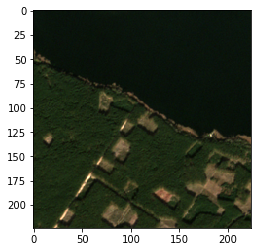

In [6]:
plt.imshow(image)

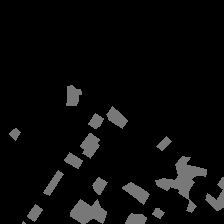

In [7]:
Image.fromarray(np.array(mask)*120)

In [8]:
img_array = np.array(image)
mask_array = np.array(mask).astype(np.float32)
image_tensor = ToTensor()(img_array).view(1, 3, 224, 224)
mask_tensor = ToTensor()(mask_array).squeeze().view(1, 224, 224).long()

In [9]:
prediction = model.forward(image_tensor)

In [10]:
prediction.shape

torch.Size([1, 3, 224, 224])

In [11]:
softmax_output = Softmax(dim=1)(prediction)
predicted_classes = softmax_output.squeeze().permute(1, 2, 0).detach().numpy()

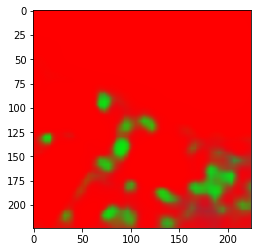

In [12]:
plt.imshow(predicted_classes)

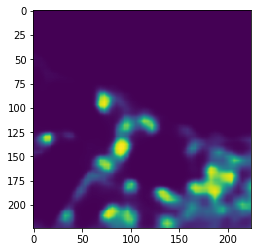

In [13]:
cleancuts = predicted_classes[:,:,1] + predicted_classes[:,:,2]
plt.imshow(cleancuts)

In [14]:
cleancuts_image = Image.fromarray(np.uint8(cleancuts*255), 'L')

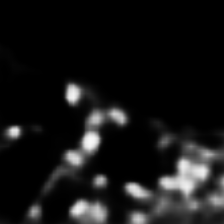

In [15]:
cleancuts_image

In [16]:
mask_image = Image.fromarray(np.uint8(mask)*100, 'L')

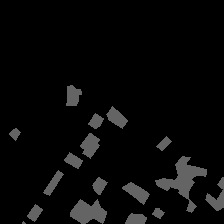

In [17]:
mask_image

In [18]:
def add_color(a):
    max_idx = np.argmax(a)
    if max_idx == 0:
        return np.array([0,0,0], dtype=np.uint8)
    elif max_idx == 1:
        return np.array([66, 244, 78], dtype=np.uint8)
    elif max_idx == 2:
        return np.array([244, 163, 65], dtype=np.uint8)
    else:
        raise ValueError()

In [19]:
colored = np.apply_along_axis(add_color, 2, predicted_classes)

In [20]:
img = Image.fromarray(colored)

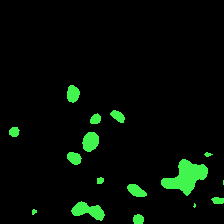

In [21]:
img

In [5]:
def dice_coef(y_true, y_pred, eps=1e-7):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + eps) / (np.sum(y_true_f) + np.sum(y_pred_f))

In [6]:
def get_inputs(datasets_path, image_info):
    name = image_info["name"] + '_' + image_info["channel"] + '_' + image_info["position"]
    image = Image.open(
        os.path.join(datasets_path, image_info["dataset_folder"], "images", name + '.' + image_info["image_type"]))
    mask = Image.open(
        os.path.join(datasets_path, image_info["dataset_folder"], "masks", name + '.' + image_info["mask_type"]))
    name = image_info["name"] + '_' + image_info["channel"] + '_' + image_info["position"]
    
    img_array = np.array(image)
    mask_array = np.array(mask).astype(np.float32)
    image_tensor = ToTensor()(img_array).view(1, 3, 224, 224)
    mask_tensor = ToTensor()(mask_array).view(1, 224, 224).long()
    return image_tensor, mask_tensor, mask_array

In [37]:
dices = []
for ind, image_info in tqdm(filenames.iterrows()):
    image_tensor, mask_tensor, mask_array = get_inputs(datasets_path, image_info)
    
    prediction = model.forward(image_tensor)
    softmax_output = Softmax(dim=1)(prediction)
    predicted_class_probs = softmax_output.squeeze().permute(1, 2, 0).detach().numpy()
    cleancuts = predicted_class_probs[:,:,1] + predicted_class_probs[:,:,2]
    
    cleancut_mask = np.uint8(mask_array!=0) > 0.5
    
    dices.append(dice_coef(cleancut_mask, cleancuts > 0.5))

153it [00:40,  3.59it/s]


In [38]:
round(np.average(dices), 4)

0.5296

In [ ]:
dices = []
for ind, image_info in tqdm(filenames.iterrows()):
    image_tensor, mask_tensor, _ = get_inputs(datasets_path, image_info)    
    prediction = model.forward(image_tensor)

    dice_score = multi_class_dice(prediction, mask_tensor)
    dices.append(dice_score)

28it [00:15,  1.53s/it]

In [ ]:
round(np.average(dices), 4)

In [7]:
def predict_class(a):
    return np.argmax(a)

In [8]:
confusion_matrix=np.zeros((2,2,2))
for ind, image_info in tqdm(filenames.iterrows()):
    image_tensor, mask_tensor, mask_array = get_inputs(datasets_path, image_info)
    
    prediction = model.forward(image_tensor)   
    softmax_output = Softmax(dim=1)(prediction)
    predicted_class_probs = softmax_output.squeeze().permute(1, 2, 0).detach().numpy()
    classes = np.apply_along_axis(predict_class, 2, predicted_class_probs)
    
    confusion_matrix += \
        multilabel_confusion_matrix(mask_array.astype(np.uint8).flatten(), classes.flatten(), labels=[1, 2])

153it [01:10,  2.55it/s]


In [9]:
confusion_matrix

array([[[7425697.,   60126.],
        [  71984.,  119121.]],

       [[7582031.,   59587.],
        [  23522.,   11788.]]])

In [10]:
# tp = confusion_matrix[:,1,1].sum()
# fp = confusion_matrix[:,0,1].sum()
# fn = confusion_matrix[:,1,0].sum()
tp = confusion_matrix[0,1,1]
fp = confusion_matrix[0,0,1]
fn = confusion_matrix[0,1,0]

In [11]:
dice = 2 * tp / (2 * tp + fp + fn)

In [12]:
dice

0.6432853069512248

In [9]:
markup = gp.read_file('../../test_data/Clearcuts_Kharkivska_190711/Clearcuts_Kharkivska_190711.geojson')

In [10]:
markup

,forest_typ,type,state,img_date,scene,comment,geometry
0,deciduous,clearcut,open,2016-01-03,S2A_OPER_MSI_L1C_TL_EPA__20160104T162841_A0027...,None,"POLYGON ((35.74328968460002 50.33710194163541,..."
1,deciduous,clearcut,open,2016-01-03,S2A_OPER_MSI_L1C_TL_EPA__20160104T162841_A0027...,None,"POLYGON ((35.7520533435336 50.33881135966537, ..."
2,deciduous,clearcut,overgrown,2016-01-03,S2A_OPER_MSI_L1C_TL_EPA__20160104T162841_A0027...,None,"POLYGON ((35.72254993093128 50.23276873309143,..."
3,deciduous,clearcut,open,2016-01-03,S2A_OPER_MSI_L1C_TL_EPA__20160104T162841_A0027...,None,"POLYGON ((35.75472938363725 50.0164416489162, ..."
4,deciduous,clearcut,overgrown,2016-01-03,S2A_OPER_MSI_L1C_TL_EPA__20160104T162841_A0027...,None,"POLYGON ((35.73585751670677 49.84682180353652,..."
5,deciduous,clearcut,overgrown,2016-01-03,S2A_OPER_MSI_L1C_TL_EPA__20160104T162841_A0027...,None,"POLYGON ((35.73180246695141 49.84711915116796,..."
6,deciduous,clearcut,open,2016-01-03,S2A_OPER_MSI_L1C_TL_EPA__20160104T162841_A0027...,None,"POLYGON ((35.74714969827763 49.84309709736512,..."
7,deciduous,clearcut,overgrown,2016-01-03,S2A_OPER_MSI_L1C_TL_EPA__20160104T162841_A0027...,None,"POLYGON ((35.74714969827762 49.84309709736512,..."
8,deciduous,clearcut,open,2016-01-03,S2A_OPER_MSI_L1C_TL_EPA__20160104T162841_A0027...,None,"POLYGON ((35.75127564896252 49.84119220282199,..."
9,deciduous,clearcut,open,2016-01-03,S2A_OPER_MSI_L1C_TL_EPA__20160104T162841_A0027...,None,"POLYGON ((35.75658543031976 49.83879030229097,..."


In [11]:
markup[markup['state'] == 'open'].area.sum()

0.005978682031662935

In [12]:
markup[markup['state'] == 'overgrown'].area.sum()

0.0019924738774187677

In [26]:
train_df = pd.read_csv(train_df_path)

confusion_matrix=np.zeros((2,2,2))
for ind, image_info in tqdm(train_df.iterrows()):
    image_tensor, mask_tensor, mask_array = get_inputs(datasets_path, image_info)
    
    prediction = model.forward(image_tensor)   
    softmax_output = Softmax(dim=1)(prediction)
    predicted_class_probs = softmax_output.squeeze().permute(1, 2, 0).detach().numpy()
    classes = np.apply_along_axis(predict_class, 2, predicted_class_probs)
    
    confusion_matrix += \
        multilabel_confusion_matrix(mask_array.astype(np.uint8).flatten(), classes.flatten(), labels=[1, 2])

609it [04:19,  2.38it/s]


In [101]:
confusion_matrix

array([[[2.9776927e+07, 1.4154200e+05],
        [3.9588200e+05, 2.4283300e+05]],

       [[3.0211475e+07, 6.7980000e+03],
        [3.3645300e+05, 2.4580000e+03]]])

In [13]:
image_tensor, mask_tensor, mask_array = get_inputs(datasets_path, filenames.iloc[0])

In [14]:
prediction = model.forward(image_tensor)

In [15]:
prediction.shape[1]

3

In [16]:
prediction.shape

torch.Size([1, 3, 224, 224])

In [17]:
num_classes = prediction.shape[1]

In [18]:
true_1_hot = torch.eye(num_classes)[mask_tensor]

In [19]:
true_1_hot.shape

torch.Size([1, 224, 224, 3])

In [20]:
true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()

In [21]:
true_1_hot.shape

torch.Size([1, 3, 224, 224])

In [22]:
true_1_hot

tensor([[[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]])

In [23]:
dims = (0,) + tuple(range(2, prediction.ndimension()))

In [24]:
dims

(0, 2, 3)

In [25]:
probas = Softmax(dim=1)(prediction)
true_1_hot = true_1_hot.type(prediction.type())

In [26]:
probas.shape

torch.Size([1, 3, 224, 224])

In [27]:
intersection = torch.sum(probas * true_1_hot, dims)
cardinality = torch.sum(probas + true_1_hot, dims)

In [28]:
intersection[1]

tensor(3677.2241, grad_fn=<SelectBackward>)

In [29]:
cardinality[1]

tensor(9402.7998, grad_fn=<SelectBackward>)

In [30]:
eps=1e-7

In [31]:
dice_score = (2. * intersection / (cardinality + eps)).mean().item()

In [32]:
dice_score

0.5864408016204834

In [33]:
(2. * intersection / (cardinality + eps)).mean()

tensor(0.5864, grad_fn=<MeanBackward0>)

In [34]:
multi_class_dice(prediction, mask_tensor, eps=1e-7)

0.5864408016204834

In [35]:
open_dice = (2. * intersection[1] / (cardinality[1] + eps)).mean()
overgrown_dice = (2. * intersection[2] / (cardinality[2] + eps)).mean()
a = (open_dice + overgrown_dice) / 2

In [36]:
a

tensor(0.3911, grad_fn=<DivBackward0>)